#Prophet model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from keras.metrics import MeanAbsoluteError
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

In [ ]:
data = pd.read_csv('electricity_demand.csv')

In [ ]:
df = data[['date', 'RRP', 'min_temperature', 'max_temperature',
       'solar_exposure', 'rainfall', 'school_day', 'holiday', 'demand']]       

In [ ]:
df['school_day'] = df['school_day'].map({'Y': 1, 'N': 0})
df['holiday'] = df['holiday'].map({'Y': 1, 'N': 0})

In [ ]:
df['date'] = df['date'].astype('datetime64[ns]')

df

,date,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,demand
0,2015-01-01,25.633696,13.3,5.186521,0.000000,0.0,0,1,99635.030
1,2015-01-02,33.138988,15.4,6.228965,0.880597,0.0,0,0,129606.010
2,2015-01-03,34.564855,20.0,6.180615,1.011321,0.0,0,0,142300.540
3,2015-01-04,25.005560,16.3,4.626013,1.051587,4.2,0,0,104330.715
4,2015-01-05,26.724176,15.0,4.690416,0.820847,0.0,0,0,118132.200
...,...,...,...,...,...,...,...,...,...
2246,2021-02-24,25.840417,11.6,4.494441,0.948498,0.0,1,0,108577.110
2247,2021-02-25,21.205833,10.7,4.929503,1.232804,0.0,1,0,107456.345
2248,2021-02-26,25.796250,12.3,4.438468,1.203822,0.4,1,0,107807.000
2249,2021-02-27,29.897083,11.1,4.312772,1.330508,0.0,0,0,103417.660


In [ ]:
date = df.iloc[:,0]
x = df.iloc[:,1:-1]
y = df.iloc[:,-1]

date = pd.DataFrame(date)
y = pd.DataFrame(y)

In [ ]:
ms_x = MinMaxScaler()
ms_y = MinMaxScaler()

In [ ]:
x_scaled = ms_x.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)
x_scaled.columns = x.columns

In [ ]:
y_scaled = ms_y.fit_transform(y)
y_scaled = pd.DataFrame(y_scaled)
y_scaled.columns = y.columns

In [ ]:
x_scaled['date'] = date['date']
x_scaled['demand'] = y_scaled['demand']

In [ ]:
x_scaled = x_scaled[['date', 'RRP', 'min_temperature', 'max_temperature',
       'solar_exposure', 'rainfall', 'school_day', 'holiday', 'demand']]   

In [ ]:
train_data = x_scaled[:int(0.975*(len(x_scaled)))]
test_data = x_scaled[int(0.975*(len(x_scaled))):]

In [ ]:
prophet_ = Prophet(interval_width=0.95, seasonality_mode='additive', n_changepoints=100, seasonality_prior_scale=25)

In [ ]:
train_data.rename({'date':'ds', 'demand':'y'}, inplace = True, axis = 'columns')
test_data.rename({'date':'ds', 'demand':'y'}, inplace = True, axis = 'columns')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
prophet_.add_regressor('min_temperature', standardize=False)
prophet_.add_regressor('max_temperature', standardize=False)
prophet_.add_regressor('solar_exposure', standardize=False)
prophet_.add_regressor('rainfall', standardize=False)
prophet_.add_regressor('RRP', standardize=False)
prophet_.add_regressor('school_day', standardize=False)
prophet_.add_regressor('holiday', standardize=False)

In [ ]:
#Training the Multivariate model
prophet_.fit(train_data)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
test_data_ = test_data.drop(columns = 'y')

In [ ]:
#Predict for the test set
future = prophet_.predict(test_data_)
predicted_data = future['yhat']

predicted_data = np.array(predicted_data)
predicted_data = predicted_data.reshape(-1,1)

In [ ]:
predicted_data = ms_y.inverse_transform(predicted_data)
real_data = test_data['y']

real_data = np.array(real_data)
real_data = real_data.reshape(-1,1)

real_data = ms_y.inverse_transform(real_data)

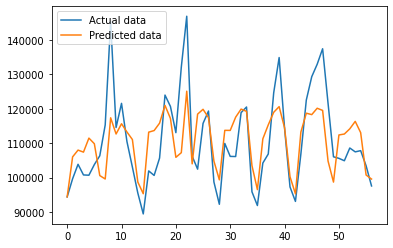

In [ ]:
plt.plot(real_data, label = "Actual data")
plt.plot(predicted_data, label = "Predicted data")
plt.legend(loc="upper left")

sns.set(rc={'figure.figsize':(30.7,20.27)})

In [ ]:
mean_absolute_error(real_data, predicted_data)

7652.744454729605

In [ ]:
r2_score(real_data, predicted_data)

0.46871670161864765

In [ ]:
import math
math.sqrt(mean_squared_error(real_data, predicted_data))

9652.502304503158

In [ ]:
mean_squared_error(real_data, predicted_data)

93170800.73843879

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(real_data, predicted_data)

6.726386044532042

#VAR model

In [ ]:
from statsmodels.tsa.api import VAR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
train_data.set_index('ds', inplace = True)
test_data.set_index('ds', inplace = True)

In [ ]:
var = VAR(train_data, freq = 'D')

In [ ]:
#Finding the best lag value which gives least AIC for the model
var.select_order(100).summary()

,AIC,BIC,FPE,HQIC
0,-35.08,-35.05,5.843e-16,-35.07
1,-39.65,-39.46*,5.999e-18,-39.58
2,-39.82,-39.46,5.070e-18,-39.69
3,-39.88,-39.34,4.786e-18,-39.68
4,-39.88,-39.17,4.803e-18,-39.62
5,-39.93,-39.04,4.576e-18,-39.60
6,-40.11,-39.05,3.811e-18,-39.72
7,-40.19,-38.96,3.515e-18,-39.74
8,-40.32,-38.91,3.101e-18,-39.80*
9,-40.31,-38.74,3.110e-18,-39.74


In [ ]:
#Building a model based on the best lag value
results = var.fit(15)

In [ ]:
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 06, May, 2021
Time:                     08:12:23
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -37.8701
Nobs:                     2179.00    HQIC:                  -39.4728
Log likelihood:           20244.9    FPE:                2.86087e-18
AIC:                     -40.3963    Det(Omega_mle):     1.85666e-18
--------------------------------------------------------------------
Results for equation RRP
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.013292         0.005516            2.410           0.016
L1.RRP                      0.235430         0.022888           10.286           0.000
L1.min_temperature         -0.001308  

In [ ]:
lag = results.k_ar

In [ ]:
#Forecast 
forecast = results.forecast(train_data.values[-lag:], steps = 57)

In [ ]:
forecast_demand = forecast[:,7]
forecast_demand = forecast_demand.reshape(-1,1)

In [ ]:
forecast_demand = ms_y.inverse_transform(forecast_demand)

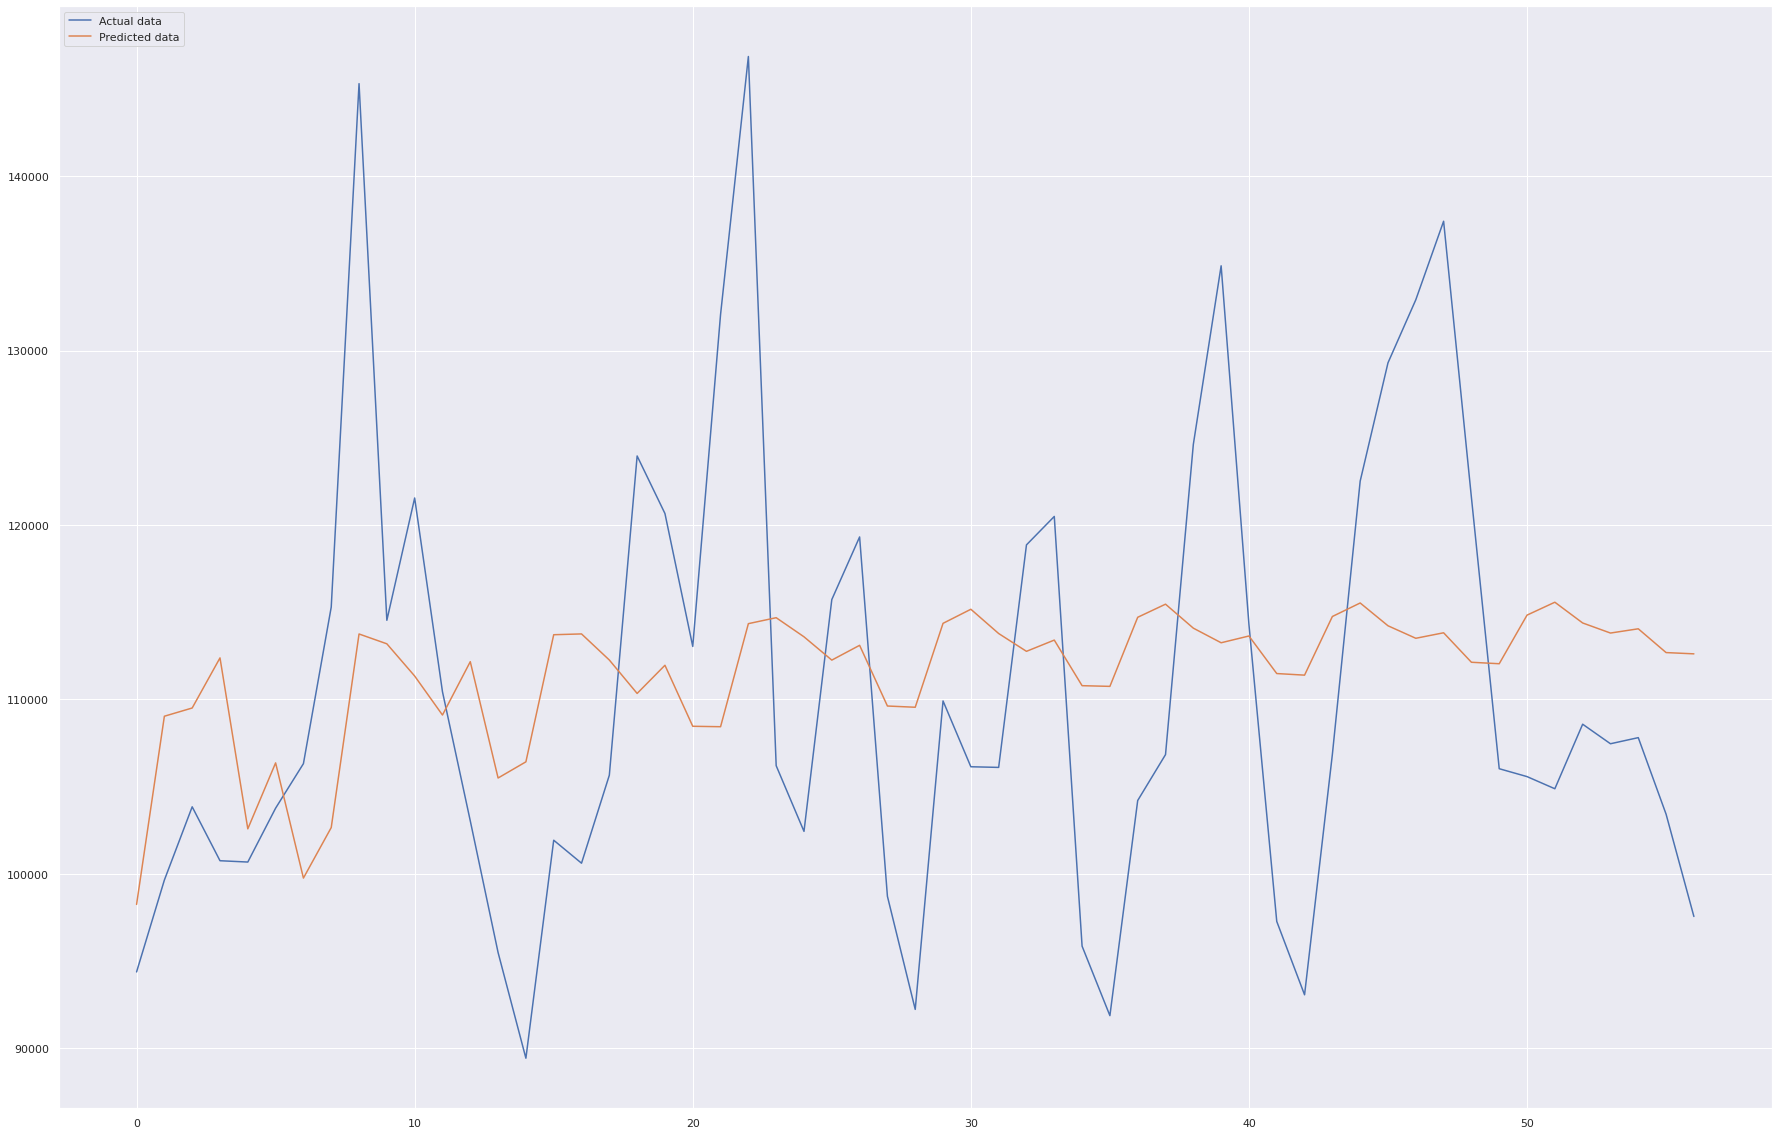

In [ ]:
plt.plot(real_data, label = "Actual data")
plt.plot(forecast_demand, label = "Predicted data")
plt.legend(loc="upper left")

sns.set(rc={'figure.figsize':(30.7,20.27)})

In [ ]:
mean_absolute_error(real_data, forecast_demand)

10716.26724197622

In [ ]:
math.sqrt(mean_squared_error(real_data, forecast_demand))

12658.560667552281

In [ ]:
mean_squared_error(real_data, forecast_demand)

160239158.17410165

In [ ]:
r2_score(real_data, forecast_demand)

0.08627608853998481

In [ ]:
mean_absolute_percentage_error(real_data, forecast_demand)

9.612650416032434

#VARMA

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [ ]:
varma = VARMAX(train_data, freq = 'D', order = (2,3))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



In [ ]:
results = varma.fit(disp=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
yhat = results.forecast(steps=len(test_data))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:159: EstimationWarning:

Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.



In [ ]:
predicted_demand = yhat.iloc[:,7]
predicted_demand = np.array(predicted_demand)
predicted_demand = predicted_demand.reshape(-1,1)

In [ ]:
forecast_demand = ms_y.inverse_transform(predicted_demand)

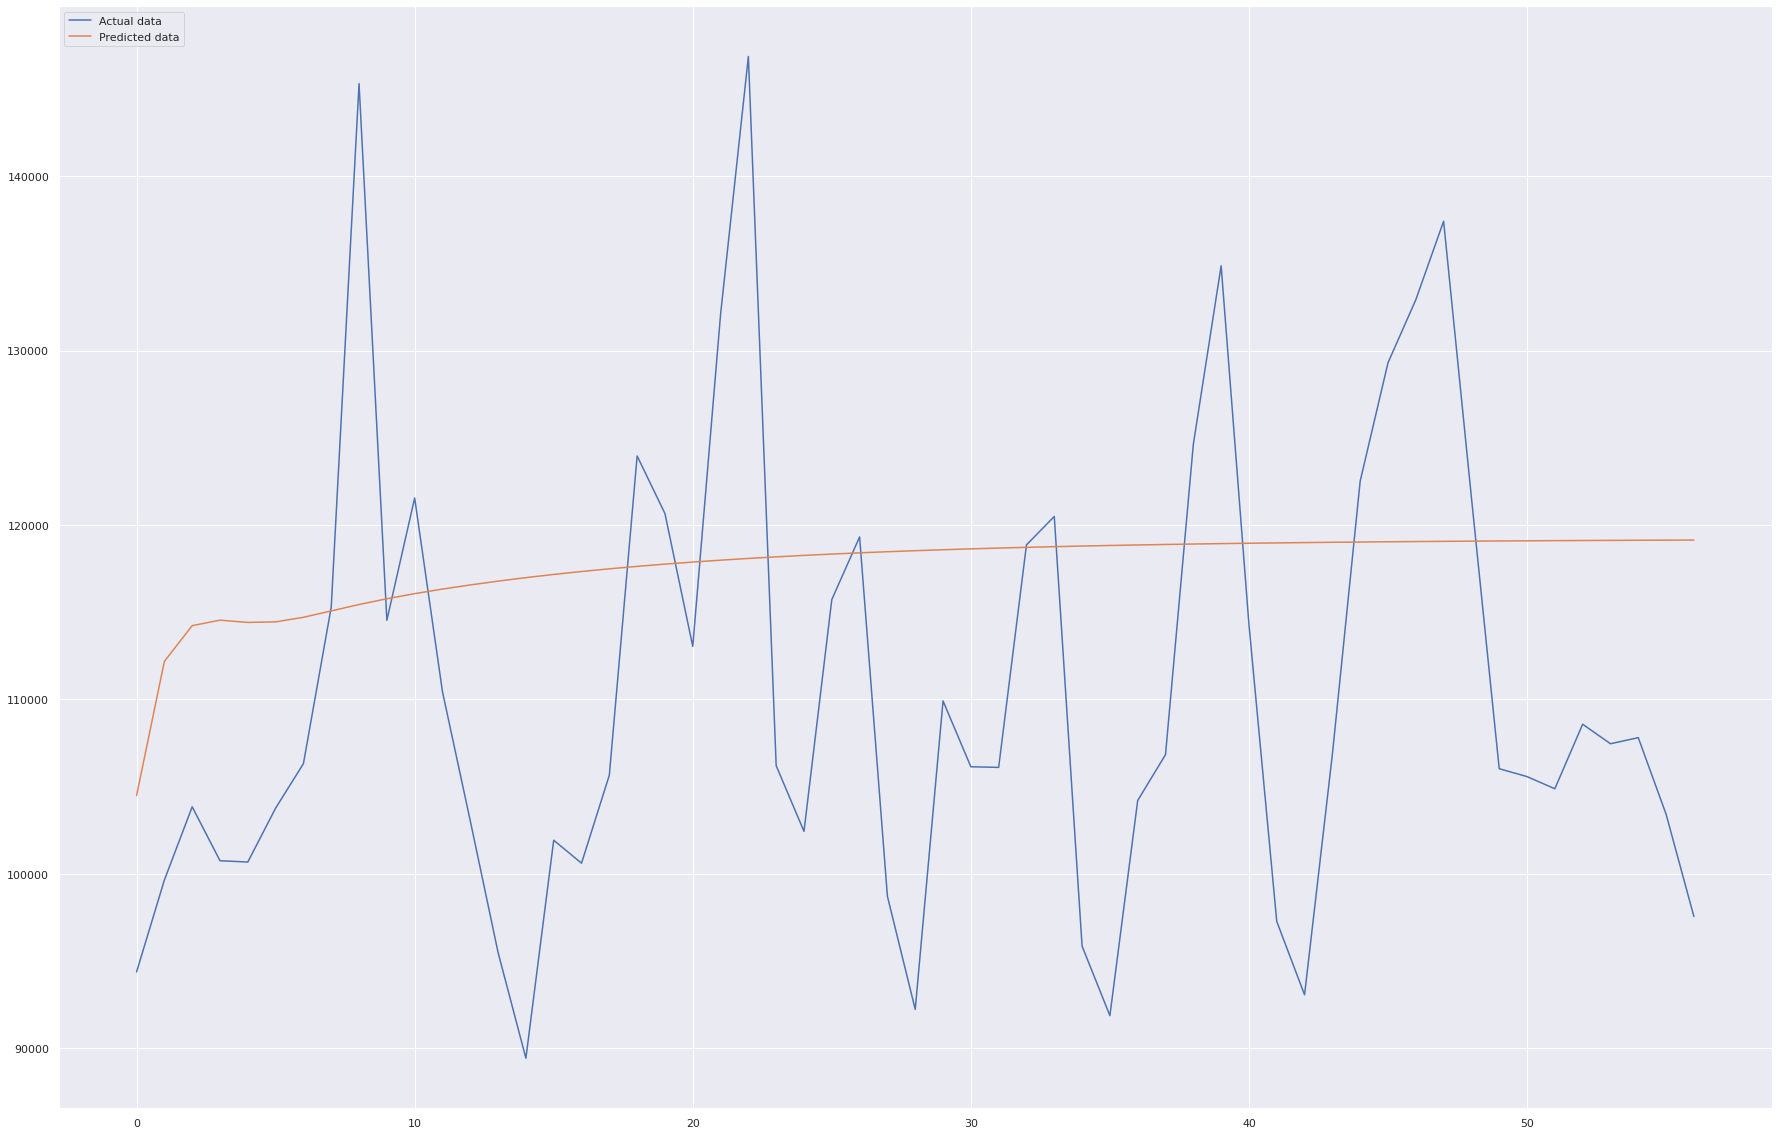

In [ ]:
plt.plot(real_data, label = "Actual data")
plt.plot(forecast_demand, label = "Predicted data")
plt.legend(loc="upper left")

sns.set(rc={'figure.figsize':(30.7,20.27)})

In [ ]:
mean_absolute_error(real_data, forecast_demand)

12654.523289109924

In [ ]:
math.sqrt(mean_squared_error(real_data, forecast_demand))

14763.117880890079

In [ ]:
mean_squared_error(real_data, forecast_demand)

217949649.56505635

In [ ]:
r2_score(real_data, forecast_demand)

-0.242803622854463

In [ ]:
mean_absolute_percentage_error(real_data, forecast_demand)

11.883048674054283